<a href="https://colab.research.google.com/github/alejandromanas/GoogleColab_public/blob/master/bookings/code/bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Booking cancellation prediction**

Before you begin, I recommend you to open this notebook in Google colab. You will be able to run python code without having a powerful computer and you can browse quickly through different sections of the document.


Booking cancellations generates a big impact on transport and hotel industries and contributes negatively to the generation of accurate forecasts. Cancellation rate can range from 20% to 60% depending on the hotel type and location. A good predictive model of cancellation could reduces losses ensuring better decision-making in the following areas:

* Booking management- Get a better forecast of net demand (bookings - cancellations)

* Revenue Management- Improves information quality (net demanad) to optimize pricing management

* Resource management- Optimize purchasing planning, services of external suppliers and staff organization. 

* Overbooking policies- Reduce the additional costs of acomodate guests in other hotels and the loss of confidence and bad publicity (bad reviews) that it can cause.

The purpose of this notebook is to show several supervised classification models that allows to predict if a hotel booking will be canceled in the future. 

The algorithms used are: 
* Logistic regression
* SVM (Support Vector Machine)
* XGBoost
* LightGBM 
* Neural network

### Libraries & basic functions

In [0]:
#import matplotlib.pyplot as plt

#import xgboost as xgb
#from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
#import lightgbm as lgb
#from sklearn.model_selection import KFold

#import warnings
#warnings.filterwarnings("ignore")



### Loading Data

Data used in the analysis was obtained from an article entitled "Hotel booking demand datasets"  and written by Nuno Antonio, Anade Almeid and Luis Nunes (https://www.sciencedirect.com/science/article/pii/S2352340918315191).

The article includes a dataset with 120,000 reservations from two hotels of one of the major portuguese hotels brand. Both hotels have more than 200 rooms and a four stars rating. One is a city hotel located in Lisbon and the other is a resort hotel in the Algarve. The reservations have an arrival date between 1st July 2015 and 31th August 2017. 

Each reservation includes about 31 features or columns. Some of them are:
* Booking status (cancelled or not cancelled)
* Lead time
* Number of nights (weekdays and weekends)
* Average price per night
* Distribution channel
* Market segment
* Room type
* Number of guests (babes, childs or adults)

Importing data from public github repository 

In [0]:
import pandas as pd

H1 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H1.csv", delimiter = ',')
H1['Hotel']='Resort'

#outcome 'IsCancelled'
H2 = pd.read_csv("https://raw.githubusercontent.com/alejandromanas/GoogleColab_public/master/bookings/files/H2.csv", delimiter = ',')
H2['Hotel']='Urban'

df_raw=[]
df_data=[]
df_raw=pd.concat([H1,H2], axis=0,ignore_index=True)

### Data Analysis

**Data overview**

In [2]:
df_analysis = df_raw.copy()
df_analysis.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


**Analysing cancelation rates**


In [0]:
import matplotlib.pyplot as plt

#overall cancelation rate
canc_rate=df_analysis.IsCanceled.sum()/len(df_analysis)*100
print('Cancelation rate mean: %.2f' % canc_rate)


df_analysis['ArrivalDateMonthNum']=df_analysis.ArrivalDateMonth.replace({ 'January' : '01', 'February' : '02', 'March' : '03', 'April' :'04', 'May': '05', 'June' : '06', 'July':'07', 'August' : '08', 'September' : '09', 'October' : '10', 'November': '11', 'December' : '12' })
df_analysis['ArrivalDateYearMonth'] = df_analysis['ArrivalDateYear'].astype('str')+'-'+ df_analysis['ArrivalDateMonthNum'].astype('str')

# GROUP BY
col_name= 'ArrivalDateYearMonth'
df=(df_analysis.groupby(['Hotel',col_name]).mean()['IsCanceled']*100).to_frame()
df.reset_index(inplace=True)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
ax = sns.lineplot(x="ArrivalDateYearMonth", y="IsCanceled", hue="Hotel", data=df,linewidth=5,palette="tab10")
ax.set_title(' % Booking cancelation by Hotel',fontsize=14)
ax.set_xlabel('Year/Month',fontsize=14);
ax.set_ylabel('% Cancellation',fontsize=14);
ax.set_xticklabels(labels=df.ArrivalDateYearMonth,rotation=70,size=12);
#plt.plot([df.ArrivalDateYearMonth[0], canc_rate], [df.ArrivalDateYearMonth.iloc[-1], canc_rate], linewidth=2)
plt.axhline(y=canc_rate, color='grey', linestyle='--',linewidth=3)
plt.show()

**Agent**

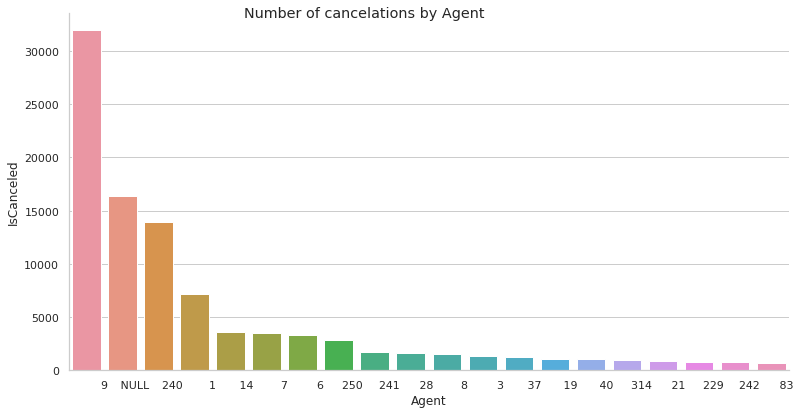

In [18]:
df_analysis.Agent.nunique() #334 unique values

def levels_analysis(feature,n):
  df=(df_analysis.groupby([feature]).count()['IsCanceled']
      .sort_values(ascending=False).head(n)).to_frame().reset_index()
  ax = sns.catplot(x=feature, y="IsCanceled", kind="bar", data=df)
  ax.fig.set_figwidth(14)
  ax.fig.set_figheight(6)
  ax.fig.suptitle('Number of cancelations by ' + feature)

  plt.show()

levels_analysis('Agent',20)

In [0]:
df=(df_analysis.groupby(['Agent']).count()['IsCanceled']/len(df_analysis))*100
df.sort_values(ascending=False).head(10)

Agent
          9    26.770249
       NULL    13.686238
        240    11.660943
          1     6.023118
         14     3.048832
          7     2.964235
          6     2.755675
        250     2.403886
        241     1.441494
         28     1.395427
Name: IsCanceled, dtype: float64

**Company**

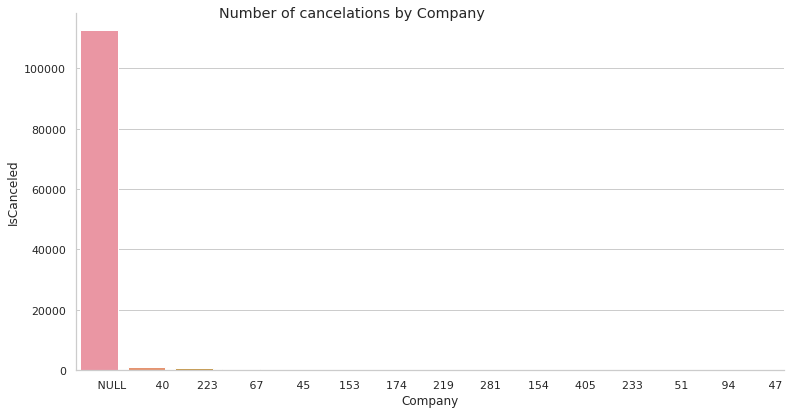

In [19]:
df_analysis.Company.nunique() #353 unique values

levels_analysis('Company',15)

For Company, 94% of rows are 'NULL'

In [0]:
  df=(df_analysis.groupby(['Company']).count()['IsCanceled']/len(df_analysis))*100
  df.sort_values(ascending=False).head(10)

Company
       NULL    94.306893
         40     0.776447
        223     0.656671
         67     0.223637
         45     0.209398
        153     0.180082
        174     0.124801
        219     0.118100
        281     0.115588
        154     0.111400
Name: IsCanceled, dtype: float64

**ADR (Average daily rate)**

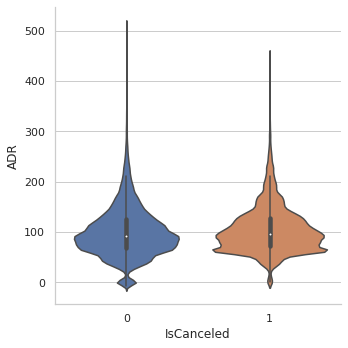

In [0]:
df=df_analysis[df_analysis['ADR']< 5000][['IsCanceled','ADR']]
#df.IsCanceled=df.IsCanceled.astype('str')
sns.catplot(x="IsCanceled", y="ADR", kind="violin", data=df)

ADR of 5400 EUR for 1 night x 2 Adults. Seems to be an error and will be deleted in preprocessing

In [0]:
df_analysis[df_analysis['ADR']> 5000]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,Hotel,ArrivalDateMonthNum,ArrivalDateYearMonth
48515,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12,NULL,0,Transient,5400.0,0,0,Canceled,2016-02-19,Urban,03,2016-03


Found booking with ADR **negative**. Sign reversed in preprocesing

In [0]:
index=df_analysis[df_analysis.ADR<0].index
df_analysis.ADR.loc[index]

14969   -6.38
Name: ADR, dtype: float64

**Lead time**

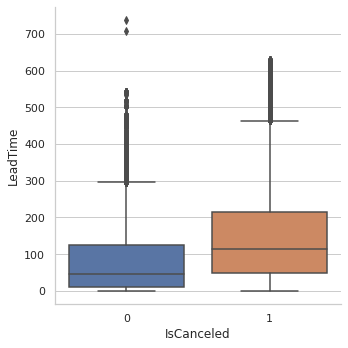

In [0]:
sns.catplot(x="IsCanceled", y="LeadTime", kind="box", data=df_analysis)

Lead time is diferent for canceled and not canceled bookings

**Booking changes**

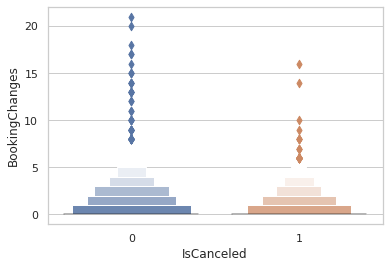

In [0]:
sns.boxenplot(x="IsCanceled", y="BookingChanges", scale="linear", data=df_analysis)

**Reservation Status**

In [0]:
df_analysis.ReservationStatus.value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: ReservationStatus, dtype: int64

Reservation Status is fixed after booking is closed (will be deleted in preprocessing)

### Preprocessing

This section includes manipulation, data cleaning and functions used in next sections

In [45]:
#Libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
#from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

import warnings
warnings.filterwarnings("ignore")

#Preprocessing
df_data=df_raw.copy()

# NAN
df_data.isnull().any() # nan found in Country & Children

# the value of the country is unreliable
# country is deleted
df_data.drop(columns = 'Country', inplace = True)

# nan in Children are replaced by 0
df_data.Children.replace(np.nan, 0,inplace = True)

# Month converted to numeric
df_data['ArrivalDateMonthNum']=df_data.ArrivalDateMonth.replace({ 'January' : 1, 'February' : 2, 'March' : 3, 'April' :4, 'May': 5, 'June' : 6, 'July':7, 'August' : 8, 'September' : 9, 'October' : 10, 'November': 11, 'December' : 12 })
df_data.drop(columns='ArrivalDateMonth',inplace=True)

# Deleting last booking change
df_data.drop(columns = 'ReservationStatusDate', inplace = True)

#Deleting Reservation Status
df_data.drop(columns = ['ReservationStatus'], inplace = True)

#ADR negative
index=df_data[df_data.ADR<0].index
df_data.ADR.loc[index]=df_data.ADR.loc[index]*-1

# ADR deleting outliers  >= 5000
df_data=df_data[df_data['ADR'] < 5000]

# Agent
#9
df_data["Agent_9"] = [1 if x == "          9" else 0 for x in df_data["Agent"]]
#null
df_data["Agent_null"] = [1 if x == "       NULL" else 0 for x in df_data["Agent"]]
#240
df_data["Agent_240"] = [1 if x == "        240" else 0 for x in df_data["Agent"]]

df_data.drop(columns = 'Agent', inplace = True)

# Company
# Company null = 1, if Company is NULL 
df_data["Company_null"] = [1 if x == "       NULL" else 0 for x in df_data["Company"]]

df_data.drop(columns = 'Company', inplace = True)

# AssignedRoomType is fixed when the customer arrives to hotel (blank for cancelated bookings) 
df_data.drop(columns = 'AssignedRoomType', inplace = True)

# Time execution mesure

def tic():
  global _start_time 
  _start_time = time.time()

def tac():
  t_sec = round(time.time() - _start_time)
  (t_min, t_sec) = divmod(t_sec,60)
  (t_hour,t_min) = divmod(t_min,60) 
  time_elapsed=print('Time elapsed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

# Metrics function

def clf_metrics(X,y,model):
  y_pred = pd.Series(model.predict(X))
  y_prob= model.predict_proba(X) 
    
  # Accuracy  
  print('Accuracy =',str(metrics.accuracy_score(y,y_pred)))
        
  # AUC
  fpr, tpr, threshold = metrics.roc_curve(y, y_prob[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  print('AUC = %0.2f' % roc_auc)
        
  # Logloss
  Logloss = metrics.log_loss(y, y_prob[:,1])
  print('LogLoss = %0.2f' % Logloss)

  # F1-score
  F1_score = metrics.f1_score(y, y_pred)
  print('F1_score = %0.2f' % F1_score)

  # Mathews correlation      
  matthews_corr = metrics.matthews_corrcoef(y, y_pred)
  print('Matthews_corr = %0.2f' % matthews_corr)
  return y_pred,y_prob

#New dataframes
X=[]
y=[]
Z=[]

X=df_data.loc[:, df_data.columns != 'IsCanceled'] #Features
y=df_data['IsCanceled'] #Outcome
Z=df_data.copy() #all data

#dummification

X=pd.get_dummies(X,drop_first=True)

#Spliting train, test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
y_train= y_train.to_numpy().ravel()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Logistic Regresion

Logistic regresion analyzes a set of data points with one or more independent variables (input variables, which may affect the outcome) and finds the best fitting model to describe the data points, using the logistic regression equation: 

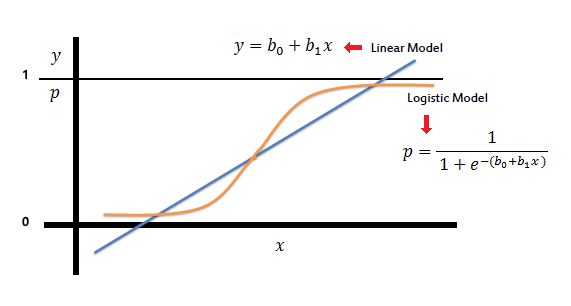

In [19]:
# Logistic regresion using pipeline with SantandarScaler & Stratified crossValidation
# scoring AUC
print('Logistic regresion pipeline')

def f_pipe_CV_logreg(X,Y):
  tic() #time mesure
  seed = 15
  scoring='roc_auc'
  sscaler = preprocessing.StandardScaler()
  log_reg = LogisticRegression(random_state=seed, solver='lbfgs', max_iter=1000)
  kfold = model_selection.StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)
  
  #pipe_logreg = make_pipeline('sscaler',sscaler,'log_reg',log_reg)
  pipe_logreg = Pipeline([
    ('sscaler',sscaler),
    ('clf',log_reg)])
  
  results_pipe_logreg = cross_val_score(pipe_logreg, X_train, y_train, cv=kfold, scoring=scoring)
  
  model_pipe_logreg=pipe_logreg.fit(X_train,y_train)
  tac()
  return model_pipe_logreg,results_pipe_logreg

model_pipe_logreg, results_pipe_logreg = f_pipe_CV_logreg(X_train,y_train)

# print metrics

print('\n***** TRAIN *****')
print('Cross validation AUC:%.4f' % results_pipe_logreg.mean(),'( +- %.4f' %results_pipe_logreg.std(),')')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,model_pipe_logreg)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,model_pipe_logreg)
    
print('\n***** ALL DATA *****')
y_pred_all,y_prob_all=clf_metrics(X,y,model_pipe_logreg)

print('\n Confusion matrix')
pd.crosstab(y_pred_all, y, rownames=['Actual'], colnames=['Predicted'])
  

Logistic regresion pipeline
Time elapsed: 0hour:0min:23sec

***** TRAIN *****
Cross validation AUC:0.8712 ( +- 0.0023 )
Accuracy = 0.819004187994416
AUC = 0.87
LogLoss = 0.41
F1_score = 0.72
Matthews_corr = 0.60

***** TEST *****
Accuracy = 0.8215930982494346
AUC = 0.88
LogLoss = 0.41
F1_score = 0.73
Matthews_corr = 0.61

***** ALL DATA *****
Accuracy = 0.8192630811883842
AUC = 0.87
LogLoss = 0.41
F1_score = 0.73
Matthews_corr = 0.60

 Confusion matrix


Predicted,0,1
Actual,,
0,68845,16168
1,6320,28055


### SVM (Support vector machine)

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def f_SVM_pipe_Gridsearch(X,Y):
  tic() #time mesure
  seed = 15
  scoring='roc_auc'
  sscaler = preprocessing.StandardScaler()
  SVC = SVC()
  kfold = model_selection.StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)
  #parameters = {'kernels': ['linear', 'rbf', 'poly']}
  parameters = {'kernels': ['linear']}
  pipe_SVC = Pipeline([ ('sscaler',sscaler), ('SVC',SVC)])
  
  #results_SVC_GridCV = cross_val_score(pipe_SVC, X_train, y_train, cv=kfold, scoring=scoring)
  SVC_GridCV = GridSearchCV(pipe_SVC, parameters, cv=2, n_jobs=1, scoring=scoring)
  model_SVC_GridCV = SVC_GridCV.fit(X_train,y_train)

  tac()
  return model_SVC_GridCV,results_SVC_GridCV

  model_SVC_GridCV,results_SVC_GridCV = f_SVM_pipe_Gridsearch(X_train,y_train)

In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

tic() #time mesure
seed = 15
scoring='roc_auc'
sscaler = preprocessing.StandardScaler()
SVM = svm.SVC()
kfold = model_selection.StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)

#parameters = {'kernels': ['linear']}
# Specify the hyperparameter space
    # Specify the hyperparameter space
parameters = {}


pipe_SVC = Pipeline([ ('sscaler',sscaler), ('SVC',SVM)])
  
#results_SVC_GridCV = cross_val_score(pipe_SVC, X_train, y_train, cv=kfold, scoring=scoring)
#SVC_GridCV = GridSearchCV(pipe_SVC, parameters, cv=2, n_jobs=1, scoring=scoring)
SVC_GridCV = GridSearchCV(pipe_SVC, parameters, cv=2, scoring=scoring)
model_SVC_GridCV = SVC_GridCV.fit(X_train,y_train)

SVM.get_params().keys()

In [0]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)

In [7]:
from sklearn import svm
X.ax[:51,'LeadTime']
x_prueba=X['LeadTime'].to_numpy()
x_prueba=x_prueba.reshape(-1, 1)
sscaler = preprocessing.StandardScaler().fit(x_prueba)
X_ss = sscaler.transform(x_prueba)
clf = svm.SVC()
clf.fit(x_prueba, y)


AttributeError: ignored

### XGboost

XGBoost is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm, which attempts to accurately predict a target variable by combining the estimates of a set of simpler, weaker models. 

In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. Each tree learns from its predecessors and updates the residual errors. Hence, the tree that grows next in the sequence will learn from an updated version of the residuals.

In [39]:
### Function
import xgboost as xgb
from xgboost import XGBClassifier
### XG Boosting with stratified CV and GridSearch

def XGBC_Boss(X,Y,params):
    
  tic()
  
  # Splitting train and test
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)   
  y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  y_test = y_test.to_numpy().ravel()    
    
  # Model
    
  xgbmodel=XGBClassifier()
     
  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'

  kfold = model_selection.StratifiedShuffleSplit(n_splits=3, random_state=15)
  grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                     param_grid = params, # param_grid
                     scoring = scoring,
                     cv = kfold,
                     n_jobs=3, 
                     refit = refit,
                     verbose = 2)
    
  model_result_xgboost = grid_solver.fit(X_train,y_train)
    
 # print('Best parameters: ',model_result_xgboost.best_estimator_)

  # return predictions
  Y_pred = pd.Series(model_result_xgboost.predict(X_train))
  Y_prob= model_result_xgboost.predict_proba(X_train)
    
  tac() # time elapsed
      
  return Y_pred,Y_prob,model_result_xgboost

# parameters

params={'base_score': [0.8], 
         'booster': ['gbtree'],
         'colsample_bylevel': [1], 
         'colsample_bytree': [0.8], 
         'gamma': [0.01],
         'learning_rate': [0.01], 
         'max_depth': [6],
         'min_child_weight': [1],
         'missing': [None],
         'n_estimators': [400],
         'n_jobs': [-1], 
         'objective': ['binary:logistic'],
         'random_state': [15], 
         'reg_alpha': [0.01], 
         'reg_lambda': [0.01],
         'scale_pos_weight': [1],
         'subsample': [0.9]}  

Y_pred,Y_prob,model_result_xgboost=XGBC_Boss(X,y,params)

# print metrics

print('\n***** TRAIN *****')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,model_result_xgboost)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,model_result_xgboost)
    
print('\n***** ALL DATA *****')
y_pred_all,y_prob_all=clf_metrics(X,y,model_result_xgboost)

print('\n Confusion matrix')
pd.crosstab(y_pred_all, y, rownames=['Actual'], colnames=['Predicted'])

Fitting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  4.2min finished


Time elapsed: 0hour:5min:51sec

***** TRAIN *****
Accuracy = 0.8279106561191252
AUC = 0.90
LogLoss = 0.38
F1_score = 0.73
Matthews_corr = 0.63

***** TEST *****
Accuracy = 0.8258648127983919
AUC = 0.90
LogLoss = 0.38
F1_score = 0.73
Matthews_corr = 0.63

***** ALL DATA *****
Accuracy = 0.8277060700734573
AUC = 0.90
LogLoss = 0.38
F1_score = 0.73
Matthews_corr = 0.63

 Confusion matrix


Predicted,0,1
Actual,,
0,70742,17135
1,4423,27088


Features used in the model

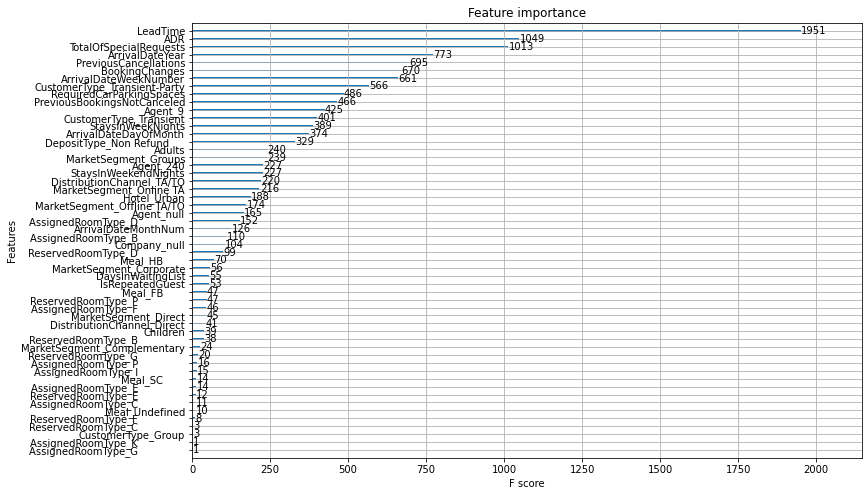

In [42]:
#xgbm=model_result_xgboost.best_estimator_

# Plot importance
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model_result_xgboost.best_estimator_,ax=ax)

### LightGBM

In [68]:
### Function
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

### LightGBM using stratified cross validation and GridSearch

def light_LGBM(X,y,param_grid):
  tic()
  seed=15
  indexes_of_categories=[]
    
  lbl = preprocessing.LabelEncoder()
    
  for i in range(X.shape[1]):
      if X.dtypes[i]=='object':
          indexes_of_categories.append(i)
          lbl.fit(X.iloc[:,i])
          X.iloc[:,i]=lbl.transform(X.iloc[:,i])
        
  # Splitting
           
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)    
  #y_train= y_train.to_numpy().ravel()   #convert to (n,) array
  #y_test = y_test.to_numpy().ravel()         
          
  gkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X=X, y=y)
     
  lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary') 

  print('Fitting...')
    
  scoring = ['roc_auc']
  refit='roc_auc'
     
  gsearch = GridSearchCV(estimator=lgb_estimator, 
                         param_grid=param_grid, 
                         cv=gkf,scoring=scoring,
                         refit=refit,
                         verbose = 2)
    
  lgb_model = gsearch.fit(X=X_train, y=y_train)
    
  print('Results ********** ')
      
  print('Best parameters:',str(lgb_model.best_params_))
   
  print('********** TRAIN ********** ')
  clf_metrics(X_train,y_train,lgb_model)
        
  print('********** TEST ********** ')
  clf_metrics(X_test,y_test,lgb_model)
    
  print('********** ALL DATA ********** ')
  y_pred,y_prob=clf_metrics(X,y,lgb_model)
     
  tac()
    
  return y_pred,y_prob,lgb_model


param_grid = {
'num_leaves': [31],
'learning_rate':[0.1],
'min_data_in_leaf': [30],
'lambda_l1': [0],
'lambda_l2': [0],
'max_depth': [3],
}  

y_pred,y_prob = light_LGBM(X,y,param_grid)

# print metrics

print('\n***** TRAIN *****')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,lgb_model)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,lgb_model)
    
print('\n***** ALL DATA *****')
y_pred_all,y_prob_all=clf_metrics(X,y,lgb_model)

print('\n Confusion matrix')
pd.crosstab(y_pred_all, y, rownames=['Actual'], colnames=['Predicted'])

Fitting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] lambda_l1=0, lambda_l2=0, learning_rate=0.1, max_depth=3, min_data_in_leaf=30, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


IndexError: ignored

### Neural network

Artificial neural networks are constructed with simple elements called neurons, which take a real value, multiply it by a weight and run a nonlinear activation function. Building several layers of neurons, each of them receives some of the input variables, passing its results to the following layers, the network can learn very complex functions. A neural network is able to learn the form of any function, given enough computational power.

In [18]:
from sklearn.neural_network import MLPClassifier

def f_pipe_CV_MLPClass(X,Y):
  tic() #time mesure
  seed = 15
  scoring='roc_auc'
  sscaler = preprocessing.StandardScaler()
  mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
  kfold = model_selection.StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)
  
  #pipe_MLPClass = make_pipeline('sscaler',sscaler,'log_reg',log_reg)
  pipe_MLPClass = Pipeline([
    ('sscaler',sscaler),
    ('mlp',mlp)])
  
  results_pipe_MLPClass = cross_val_score(pipe_MLPClass, X_train, y_train, cv=kfold, scoring=scoring)
  
  model_pipe_MLPClass=pipe_MLPClass.fit(X_train,y_train)
  tac()
  return model_pipe_MLPClass,results_pipe_MLPClass

model_pipe_MLPClass, results_pipe_MLPClass = f_pipe_CV_MLPClass(X_train,y_train)

# print metrics

print('\n***** TRAIN *****')
print('Cross validation AUC:%.4f' % results_pipe_MLPClass.mean(),'( +- %.4f' %results_pipe_MLPClass.std(),')')
y_pred_train,y_prob_train=clf_metrics(X_train,y_train,model_pipe_MLPClass)
        
print('\n***** TEST *****')
y_pred_test,y_prob_test=clf_metrics(X_test,y_test,model_pipe_MLPClass)
    
print('\n***** ALL DATA *****')
y_pred_all,y_prob_all=clf_metrics(X,y,model_pipe_MLPClass)

print('\n Confusion matrix')
pd.crosstab(y_pred_all, y, rownames=['Actual'], colnames=['Predicted'])
  

Time elapsed: 0hour:4min:4sec

***** TRAIN *****
Cross validation AUC:0.9055 ( +- 0.0026 )
Accuracy = 0.849455560725919
AUC = 0.92
LogLoss = 0.33
F1_score = 0.78
Matthews_corr = 0.67

***** TEST *****
Accuracy = 0.8434542256470391
AUC = 0.91
LogLoss = 0.35
F1_score = 0.77
Matthews_corr = 0.66

***** ALL DATA *****
Accuracy = 0.8488554221913241
AUC = 0.92
LogLoss = 0.33
F1_score = 0.78
Matthews_corr = 0.67

 Confusion matrix


Predicted,0,1
Actual,,
0,69658,13644
1,5507,30579
